In [1]:
'''Examination of the variance in the likelihood estimate of the particle filter for varying number of particles N with the Toy example 
in section 16.5.1 on Introduction to SMC By Chopin and Papaspiliopoulos.'''

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

from particle_filter import filter
from pmcmc import PMCMC
from kf_mcmc import KMCMC
from models import AR_model
from scipy.stats import norm,uniform,gamma

In [2]:
rng = np.random.Generator(np.random.MT19937(0))

# '''Model'''

model_params = {'rho':0.9,'sigma_x':0.8,'sigma_y':1.2}

T = 300

# X = np.zeros((T,))
# X[0] = 0. 

# Y = np.zeros((T,))
# Y[0] = 0. 

Y = pd.read_csv('AR_Test_Observation.csv',header = None, index_col=False).to_numpy().squeeze()
X = pd.read_csv('AR_Test_States.csv',header = None, index_col=False).to_numpy().squeeze()

# for t in range(1,T): 
#     X[t] = model_params['rho'] * X[t-1] + rng.normal(0,model_params['sigma_x'])
#     Y[t] = X[t] + rng.normal(0,model_params['sigma_y'])


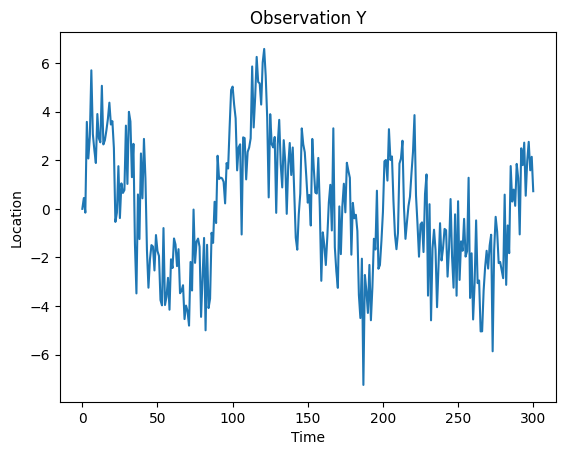

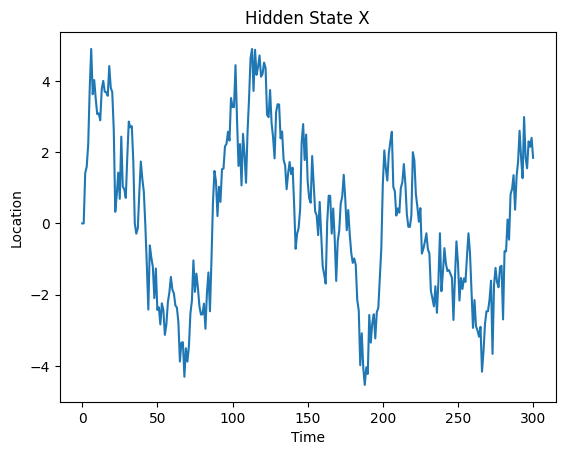

In [3]:
plt.title("Observation Y")
plt.ylabel('Location')
plt.xlabel('Time')
plt.plot(Y)
plt.show()

plt.title("Hidden State X")
plt.ylabel('Location')
plt.xlabel('Time')
plt.plot(X)
plt.show()

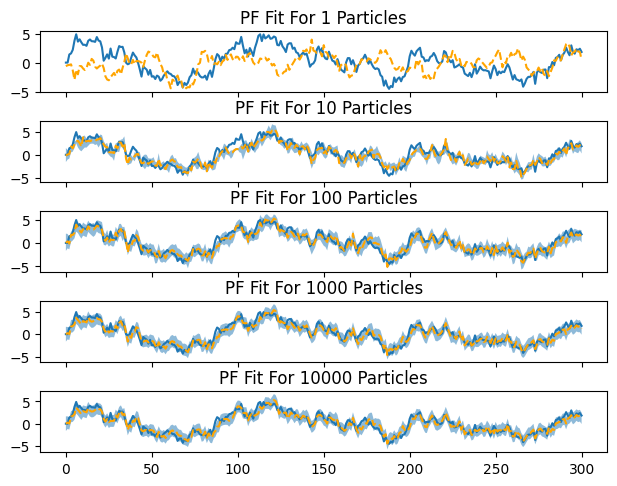

In [4]:
'''PF fit for 100 particles'''
fig, ax = plt.subplots(5, 1, sharex=True)
fig.tight_layout()

num_particles_list = [1,10,100,1000,10_000]

for i,num_particles in enumerate(num_particles_list):

    particles,weights,likelihood = filter(Y,theta = (model_params['rho'],model_params['sigma_x'],model_params['sigma_y']),dt = 1,rng = rng, model = AR_model,num_particles=num_particles,model_dim = 1)

    ax[i].set_title(f"PF Fit For {num_particles} Particles")
    ax[i].plot(np.arange(0,len(Y)),np.average(particles[:,0,:],weights = weights,axis = 0),'--',color = 'orange',zorder = 12)
    ax[i].plot(X)
    ax[i].fill_between(np.arange(0,len(Y)),np.percentile(particles[:,0,:],5,axis = 0),np.percentile(particles[:,0,:],95,axis = 0),alpha = 0.5)

Statistics for 1 particles:
Variance is 94648.21653852527 and mean is -1393.1007317443905
Statistics for 10 particles:
Variance is 39.53175796075838 and mean is -604.1523421535725
Statistics for 100 particles:
Variance is 2.1371904706423495 and mean is -581.4771087924464
Statistics for 1000 particles:
Variance is 0.1607978370967178 and mean is -579.4793434256138
Statistics for 10000 particles:
Variance is 0.033100828912137295 and mean is -579.6529701632411


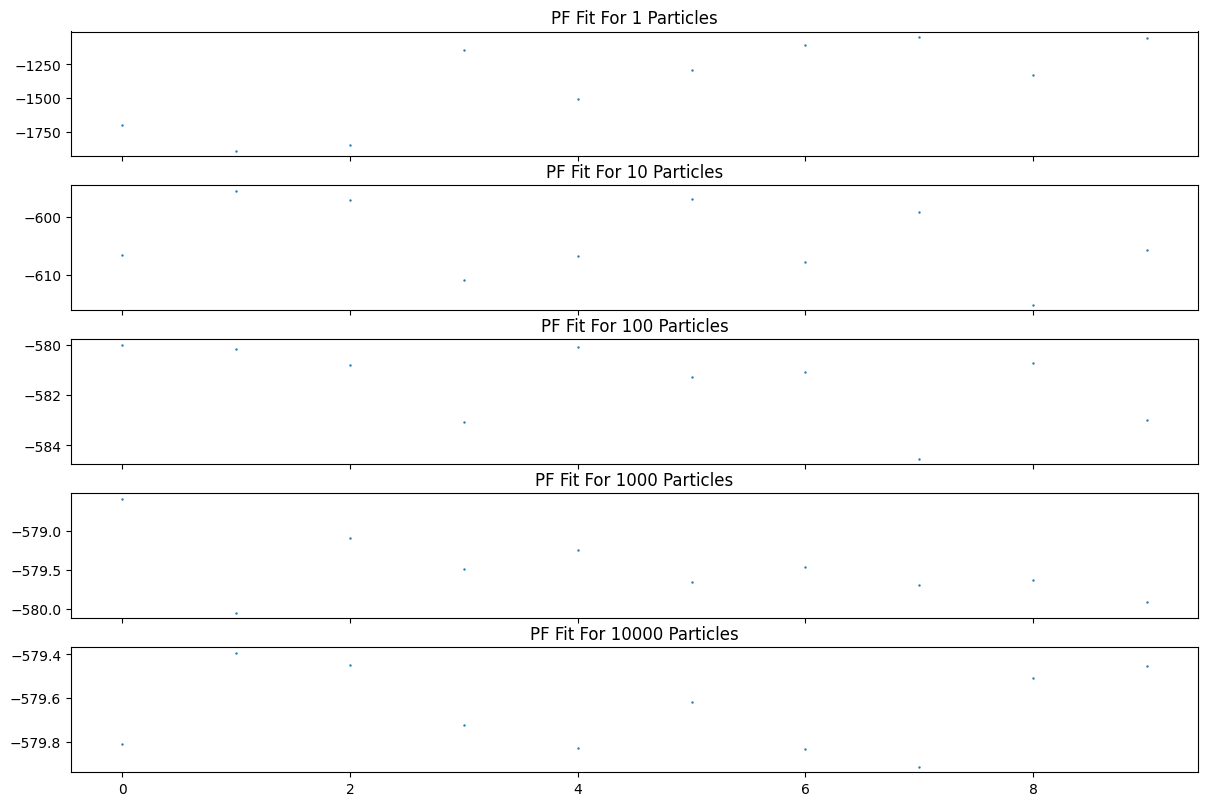

In [5]:
iterations = 10
num_particles = [1,10,100,1000,10_000]

fig, ax = plt.subplots(5, 1, sharex=True,figsize = (12,8))
fig.tight_layout()

for i in range(len(num_particles)):
    LL_s = []
    for iter in range(iterations):
        *_,likelihood = filter(Y,theta = (model_params['rho'],model_params['sigma_x'],model_params['sigma_y']),dt = 1,rng = rng, model = AR_model,num_particles=num_particles[i],model_dim = 1)
        LL_s.append(np.sum(np.log(likelihood)))


    ax[i].set_title(f"PF Fit For {num_particles[i]} Particles")
    ax[i].scatter(np.arange(0,iterations,1),LL_s,s=0.5)

    print(f"Statistics for {num_particles[i]} particles:")
    print(f"Variance is {np.var(LL_s)} and mean is {np.mean(LL_s)}")






### <center> Likelihood Computation Using the Kalman Filter

The Hidden Markov Model is defined as follows. A latent process is given where $A \in \mathbb{R}^{p \times k}$ and $F \in \mathbb{R}^{k \times k}$ and 
$v_t,w_t$ are vectors of parameterized Gaussian noise. 

$$
y_t = Ax_t + v_t \\
x_t = Fx_{t-1} + w_t \\
w_t \sim \mathcal{N}(0,W)\\
v_t \sim \mathcal{N}(0,V)


$$

Formally, the Likelihood for a Hidden Markov Model is the unnormalized joint density $p(y_1,\dots,y_T)$ for some time series of observations of a latent process indexed by $1,2,\dots,T$. We can factorize as follows by the conditional independence assumptions of the Markov process. 

$$
p(y_1)\prod_{i=2}^T p(y_i|y_{1:i-1})
$$

First we need to compute $p(y_1)$. We can do so by considering the joint density $p(y_1,x_1)$ and integrating with respect to $x_1$. 

$$
p(y_1,x_1) = p(y_1|x_1)p(x_1) \\
p(y_1) = \int p(y_1|x_1)p(x_1) dx_1
$$

Note that $p(y_1|x_1)$ is the observation density, and $p(x_1)$ is the posterior density the latent state. 

Thus we can write $p(y_1|x_1) = \mathcal{N}(Ax_0^{forecast},V)$ and $\mathcal{N}(Fx_0^{forecast},FP_{0}^{forecast}F^T + W)$ where superscript denotes the posterior estimate and $P$ is the running covariance in the Kalman Filter.

$$
\int \mathcal{N}(Ax_0^{forecast},V) \mathcal{N}(Fx_0^{forecast},FP_{0}^{forecast}F^T + W) dx_0 \\
= \mathcal{N}(Ax_0^{forecast},AP_{0}^{forecast}A^T + V)
$$

In general we require densities of the form $p(y_i|y_{1:i-1})$ which can be factorized as follows. 

$$
p(y_i|y_{1:i-1}) = \int p(y_i,x_i|y_{1:i-1}) dx_i \\
= \int p(y_i|x_i)p(x_i|y_{1:i-1})dx_i \\
=\mathcal{N}(Ax_{i-1}^{forecast},AP_{i-1}^{forecast}A^T + V)
$$

Thus the full log likelihood takes the form 

$$
\mathcal{L}(\theta) = \sum\limits_{i=1}^T \log p(y_i|y_{1:i-1})
$$

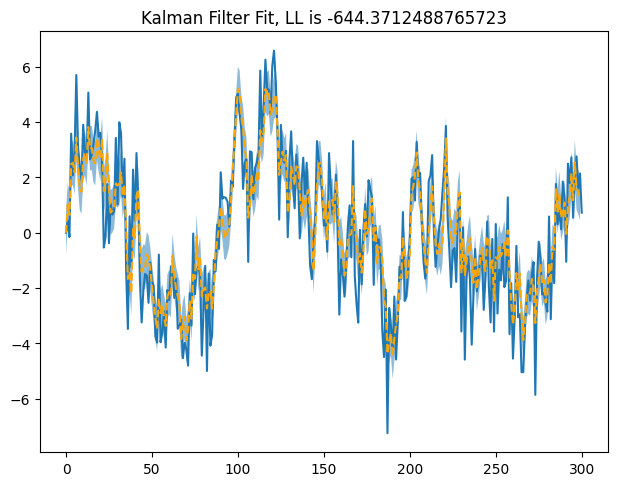

In [6]:
'''Implementation of the Kalman Filter'''

posterior_mean = np.zeros(T)
posterior_cov = np.zeros(T)

posterior_mean[0] = 0
posterior_cov[0] = 1

LL = np.zeros(T)

for time_index in range(T):

    '''Forecast'''
    if(time_index > 0):
        posterior_mean[time_index] = model_params['rho'] * posterior_mean[time_index-1] + rng.normal(0,model_params['sigma_x'])
        posterior_cov[time_index] = model_params['rho'] * posterior_cov[time_index-1] * model_params['rho'] + model_params['sigma_x']**2

    '''Likelihood'''
    LL[time_index] = norm.logpdf(x = Y[time_index], loc = posterior_mean[time_index],scale = np.sqrt(posterior_cov[time_index] + model_params['sigma_y']**2))

    '''Update'''
    K = posterior_cov[time_index] / (posterior_cov[time_index] + model_params['sigma_y']**2)

    posterior_mean[time_index] = posterior_mean[time_index] + K * (Y[time_index] - posterior_mean[time_index])
    posterior_cov[time_index] = (1 - K) * posterior_cov[time_index]

fig, ax = plt.subplots(1, sharex=True)
fig.tight_layout()  
ax.set_title(f'Kalman Filter Fit, LL is {np.sum(LL)}')
ax.plot(Y)
ax.plot(posterior_mean,'--',color = 'orange',zorder = 12)
ax.fill_between(np.arange(0,T), posterior_mean - np.sqrt(posterior_cov),posterior_mean + np.sqrt(posterior_cov),alpha = 0.5)

In [7]:
'''Running PMMH to estimate the model parameters'''

prior = lambda x: uniform.logpdf(x[0],-1,2) + gamma.logpdf(x[1],2,1/2) + gamma.logpdf(x[2],2,1/2)
theta, LL = PMCMC(iterations=10_000,
                  num_particles=1000,
                  init_theta=np.array([rng.uniform(-1,1),rng.gamma(2,1/2),rng.gamma(2,1/2)]),
                  data = Y,
                  rng = rng,
                  dt = 1, 
                  prior = prior, 
                  model = AR_model,
                  model_dim=1)


c:\Users\avery\Avery's Work\PMCMC\pmcmc.py:48: RuntimeWarning: invalid value encountered in scalar subtract
  ratio = (LL_new - LL[iter-1])


iteration: 10| Acceptance rate: 0.1| Log-Likelihood: -752.4399777326344
iteration: 20| Acceptance rate: 0.05| Log-Likelihood: -752.4399777326344
iteration: 30| Acceptance rate: 0.03333333333333333| Log-Likelihood: -752.4399777326344
iteration: 40| Acceptance rate: 0.025| Log-Likelihood: -752.4399777326344
iteration: 50| Acceptance rate: 0.02| Log-Likelihood: -752.4399777326344
iteration: 60| Acceptance rate: 0.016666666666666666| Log-Likelihood: -752.4399777326344
iteration: 70| Acceptance rate: 0.014285714285714285| Log-Likelihood: -752.4399777326344
iteration: 80| Acceptance rate: 0.0125| Log-Likelihood: -752.4399777326344
iteration: 90| Acceptance rate: 0.011111111111111112| Log-Likelihood: -752.4399777326344
iteration: 100| Acceptance rate: 0.01| Log-Likelihood: -752.4399777326344
iteration: 110| Acceptance rate: 0.00909090909090909| Log-Likelihood: -752.4399777326344
iteration: 120| Acceptance rate: 0.008333333333333333| Log-Likelihood: -752.4399777326344
iteration: 130| Acceptanc

c:\Users\avery\Avery's Work\PMCMC\pmcmc.py:73: RuntimeWarning: overflow encountered in multiply
  cov = cov * 2.38**2/(len(theta_val))
c:\Users\avery\Avery's Work\PMCMC\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:3410: RuntimeWarning: invalid value encountered in subtract
  return sc.xlogy(a-1.0, x) - x - sc.gammaln(a)


iteration: 1490| Acceptance rate: 0.0006711409395973154| Log-Likelihood: -752.4399777326344
iteration: 1500| Acceptance rate: 0.0006666666666666666| Log-Likelihood: -752.4399777326344
iteration: 1510| Acceptance rate: 0.0006622516556291391| Log-Likelihood: -752.4399777326344
iteration: 1520| Acceptance rate: 0.0006578947368421052| Log-Likelihood: -752.4399777326344
iteration: 1530| Acceptance rate: 0.00065359477124183| Log-Likelihood: -752.4399777326344
iteration: 1540| Acceptance rate: 0.0006493506493506494| Log-Likelihood: -752.4399777326344
iteration: 1550| Acceptance rate: 0.0006451612903225806| Log-Likelihood: -752.4399777326344
iteration: 1560| Acceptance rate: 0.000641025641025641| Log-Likelihood: -752.4399777326344
iteration: 1570| Acceptance rate: 0.0006369426751592356| Log-Likelihood: -752.4399777326344
iteration: 1580| Acceptance rate: 0.0006329113924050633| Log-Likelihood: -752.4399777326344
iteration: 1590| Acceptance rate: 0.0006289308176100629| Log-Likelihood: -752.43997

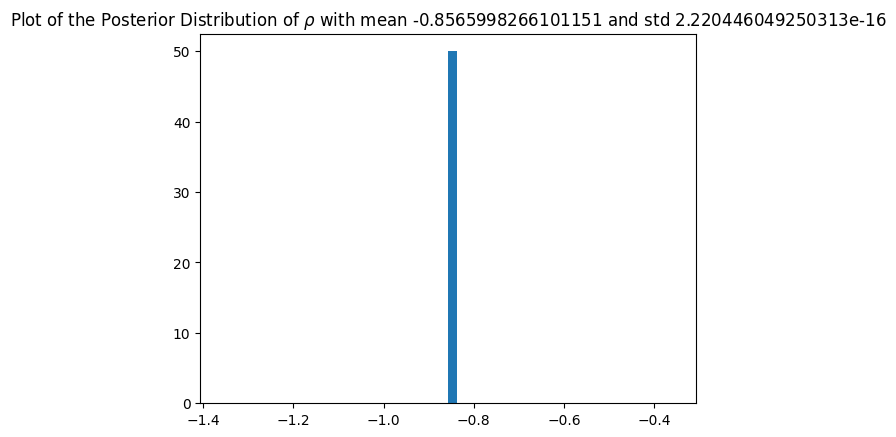

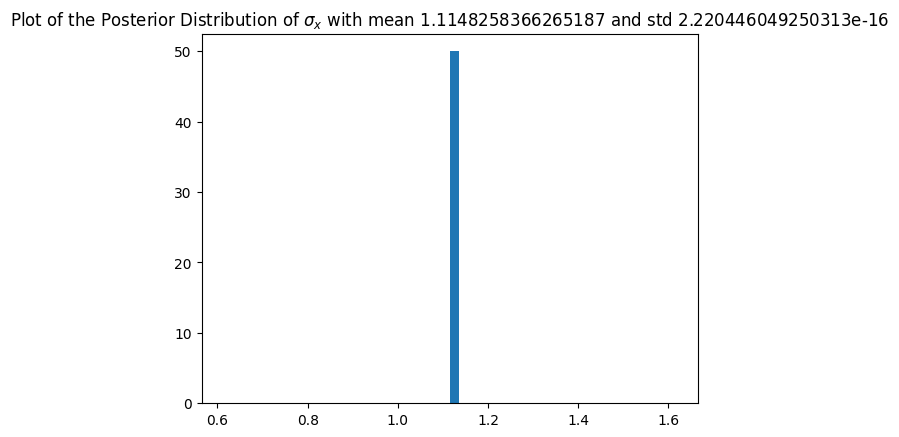

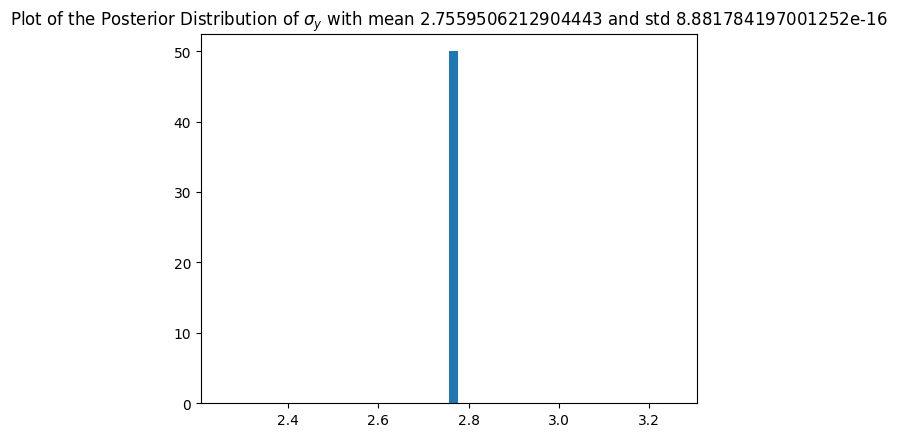

In [10]:
burn_in = 1000
plt.title(f'Plot of the Posterior Distribution of $\\rho$ with mean {np.mean(theta[0,burn_in:])} and std {np.std(theta[0,burn_in:])}')
plt.hist(theta[0,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f'Plot of the Posterior Distribution of $\\sigma_x$ with mean {np.mean(theta[1,burn_in:])} and std {np.std(theta[1,burn_in:])}')
plt.hist(theta[1,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f'Plot of the Posterior Distribution of $\\sigma_y$ with mean {np.mean(theta[2,burn_in:])} and std {np.std(theta[2,burn_in:])}')
plt.hist(theta[2,burn_in:],density=True,bins = 50)
plt.show()

Text(0.5, 0, 'Iteration')

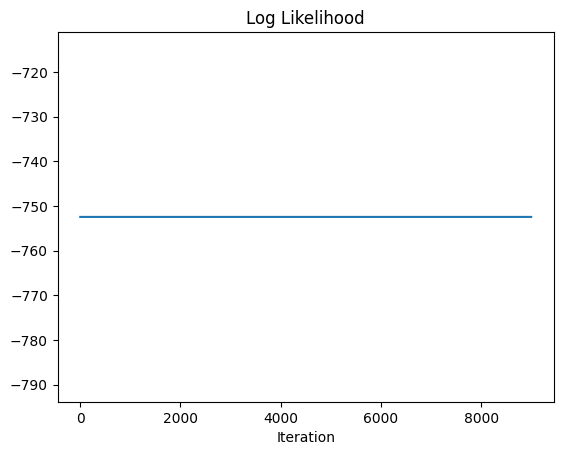

In [9]:
plt.title('Log Likelihood')
plt.plot(LL[burn_in:])
plt.xlabel('Iteration')